In [1]:
#import important modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import math as mth
from PIL import Image, ImageDraw
import seaborn as sns

## Visualize landmarks ##

* Plot landmark positions for respective images.
* Visualize tangents to the landmarks

C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/all landmark estimation/groundtruth for 68 landmarks detection/train/sunhl-1th-09-Jan-2017-192 B AP.jpg
(977, 390, 3)
[0.47692  0.62821  0.47436  0.61795  0.46923  0.61538  0.47179  0.60513
 0.45897  0.59744  0.45385  0.59231  0.45385  0.57692  0.45385  0.58718
 0.45897  0.57179  0.44615  0.56923  0.44872  0.56154  0.41795  0.53846
 0.41538  0.52821  0.37692  0.49487  0.36667  0.47949  0.32564  0.46667
 0.32564  0.44615  0.29487  0.4359   0.29487  0.41282  0.28205  0.42308
 0.27692  0.41026  0.28718  0.44103  0.29487  0.43846  0.3      0.45897
 0.30769  0.46667  0.33077  0.49231  0.32308  0.49487  0.34359  0.50769
 0.34103  0.51795  0.34615  0.50769  0.34872  0.51282  0.33846  0.51282
 0.3359   0.50513  0.31026  0.50256  0.016377 0.0174   0.039918 0.045036
 0.053224 0.054248 0.073695 0.081883 0.087001 0.094166 0.11873  0.12282
 0.13511  0.13613  0.16172  0.16274  0.16991  0.17093  0.20164  0.20573
 0.20983  0.21801  0.2384

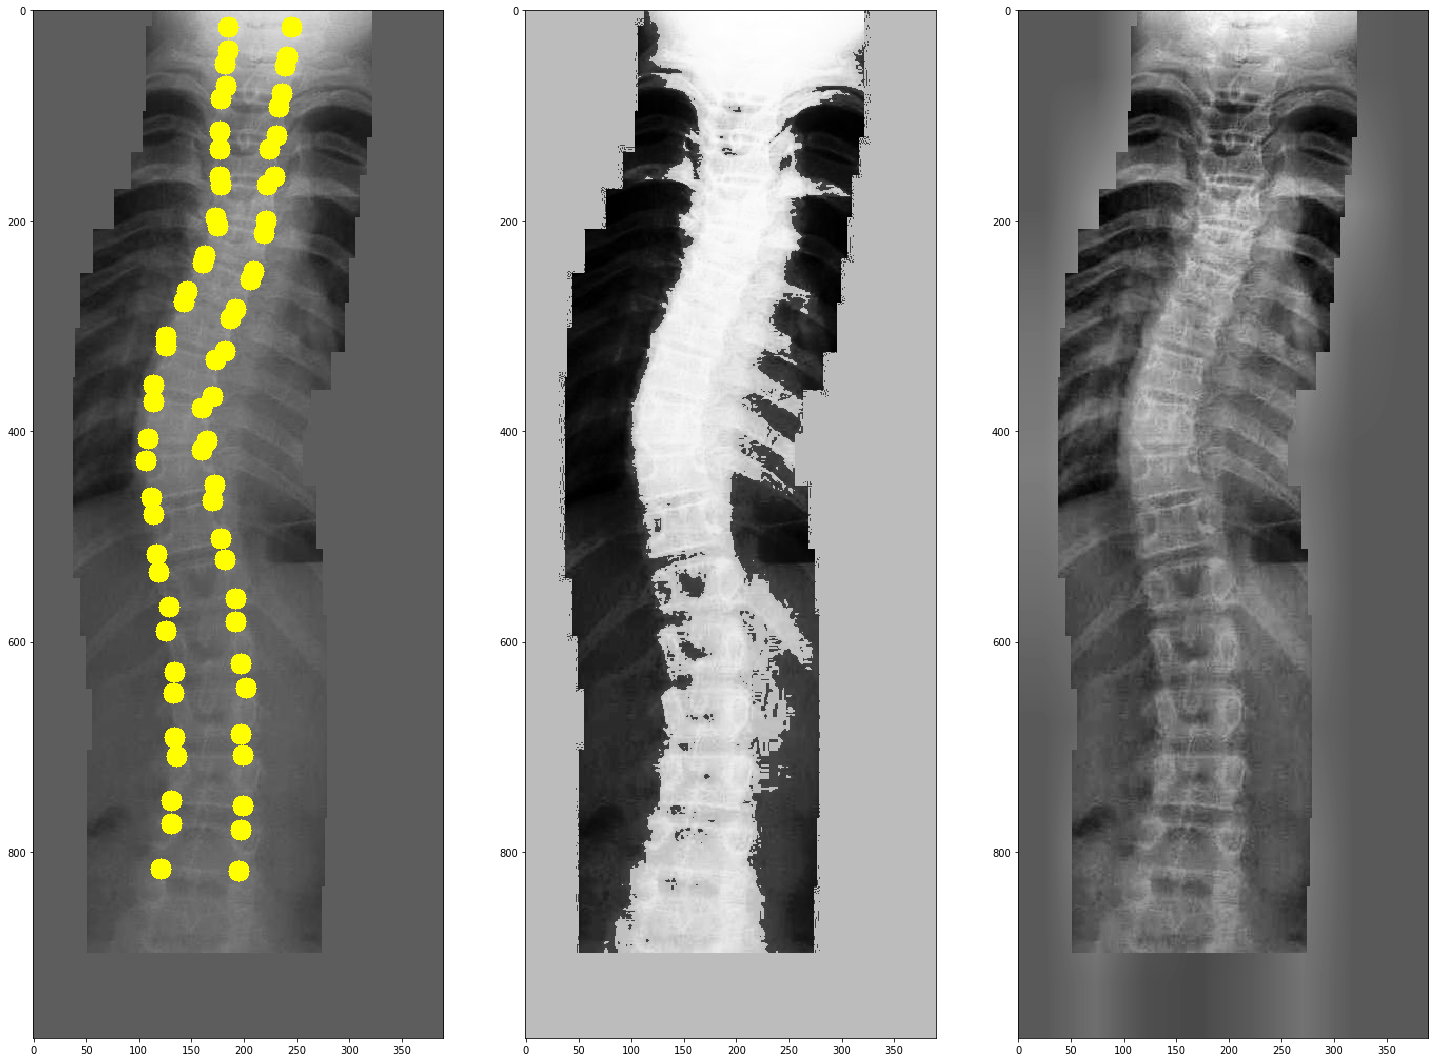

In [6]:

filename = "sunhl-1th-09-Jan-2017-192 B AP.jpg"
#image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/training/"
#label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/training/"
image_directory="C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/all landmark estimation/groundtruth for 68 landmarks detection/train/"
label_directory="C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/all landmark estimation/groundtruth for 68 landmarks detection/"
image = image_directory+filename

print (image_directory+filename)
img = cv2.imread(image)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

data= pd.read_csv(label_directory+"train_landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"train_filenames.csv",header= None)

print (img.shape)
indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmark= data.iloc[indx[0]].values
print (landmark)
cnt=[]
for m in range(0,68):
    cv2.circle(img,(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])), 10, (0,255,255), -1)

    

plt.figure(1, figsize=(25,25))


plt.subplot(131)
plt.imshow(img[:,:,::-1])

plt.subplot (132)
plt.imshow(equ, cmap= cm.gray)

plt.subplot (133)
plt.imshow(cl1, cmap= cm.gray)


In [51]:
def find_cobb_angles(vertebra_slopes):
    
    cobb_angles= [0.0,0.0,0.0]
    if not isinstance(vertebra_slopes, np.ndarray):
        vertebra_slopes= np.array(vertebra_slopes)
    
    max_slope = np.amax(vertebra_slopes)
    min_slope= np.amin(vertebra_slopes)
    
    lower_MT= np.argmax(vertebra_slopes)
    upper_MT = np.argmin(vertebra_slopes)
    
    if lower_MT < upper_MT:
        lower_MT, upper_MT = upper_MT, lower_MT
    

    upper_max_slope= np.amax(vertebra_slopes[0:upper_MT+1])
    upper_min_slope = np.amin(vertebra_slopes[0:upper_MT+1])

    lower_max_slope=np.amax(vertebra_slopes[lower_MT:17])
    lower_min_slope=np.amin(vertebra_slopes[lower_MT:17])


    cobb_angles[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
    cobb_angles[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
    cobb_angles[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))
    
    return cobb_angles
    
    

In [56]:
def make_csv_cobb_angles(image_directory, filenames_csv, landmarks_csv, split_type= 'train'):
    
    landmarks_data= pd.read_csv(landmarks_csv,header= None)
    filename_labels= pd.read_csv(filenames_csv,header= None)
    
    df= pd.DataFrame(columns=['image_id', 'MT','PT','TL'])

    
    for i, names in enumerate(filename_labels.iloc[:,0]):
        
        img = cv2.imread(image_directory+names)
        landmarks = landmarks_data.loc[i].values
        avg_slopes=[]
        for m in range (0,68,4):
            slope1 = (round(img.shape[0]*landmarks[m+1+68])-round(img.shape[0]*landmarks[m+68]))/(
                     round(img.shape[1]*landmarks[m+1])-round(img.shape[1]*landmarks[m]))
            slope2 = (round(img.shape[0]*landmarks[m+3+68])-round(img.shape[0]*landmarks[m+2+68]))/(
                    round(img.shape[1]*landmarks[m+3])-round(img.shape[1]*landmarks[m+2]))
            avg_slopes.append((slope1+slope2)/2)
        cobb_angles= find_cobb_angles(avg_slopes)
        print (cobb_angles)
        df= df.append({'image_id': names, 'MT': cobb_angles[0],
                       'PT': cobb_angles[1],'TL': cobb_angles[2]}, ignore_index=True)
        csv_file= split_type + "_cobb_angles"+".csv"
        df.to_csv(csv_file,index= False)

In [ ]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/"
train_data_directory = os.path.join(ROOT_PATH, "data/train/")
val_data_directory = os.path.join(ROOT_PATH, "data/val/")
train_label_directory=os.path.join(ROOT_PATH, "data/labels/train/")
val_label_directory =os.path.join(ROOT_PATH, "data/labels/val/")

make_csv_cobb_angles(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),
         os.path.join(train_label_directory,'landmarks.csv'), 'train')

#make_csv_cobb_angles(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),
#         os.path.join(val_label_directory,'landmarks.csv'), 'train')


[0.05311743341404358, 0.08569500674763833, 0.10185185185185185, 0.02003205128205128, 0.053030303030303025, 0.2504835589941973, 0.366600790513834, 0.30681818181818177, 0.218568665377176, 0.07430830039525692, -0.17820512820512818, -0.22811059907834103, -0.16833077316948286, -0.12185167910447761, -0.052795031055900624, 0.013786764705882353, 0.06545454545454546]
Maximum Tilted vertebra 6 11
 Their Slopes:  [0.05311743341404358, 0.08569500674763833, 0.10185185185185185, 0.02003205128205128, 0.053030303030303025, 0.2504835589941973, 0.366600790513834]
Upper max-min slopes:  0.366600790513834 0.02003205128205128
Lower max-min slopes:  0.06545454545454546 -0.22811059907834103
20.13297624381977 1.1475985059201887
 Cobb angles [32.98288266947249, 18.98537773789958, 16.594833599194793]


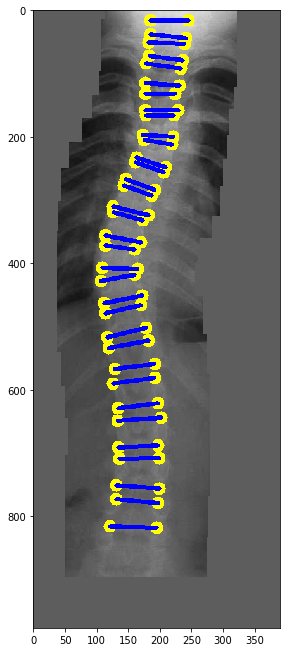

In [7]:
slopes =[]
avg_slopes=[]
lines = []
cobb_angles= [0.0,0.0,0.0]
for m in range (0,68,2):
    slope = (round(img.shape[0]*landmark[m+1+68])-round(img.shape[0]*landmark[m+68]))/(round(img.shape[1]*landmark[m+1])-round(img.shape[1]*landmark[m]))
    #print (landmark[m+68])
    slopes.append(slope)
    lines.append(((int(img.shape[1]*landmark[m+1]),int(img.shape[0]*landmark[m+1+68])),(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68]))))

for s in range (0,34,2):
    avg_slopes.append((slopes[s]+slopes[s+1])/2)

avg_slope = np.array(avg_slopes)
max_slope = np.amax(avg_slopes)
min_slope= np.amin(avg_slopes)
if np.argmax(avg_slopes)> np.argmin(avg_slopes):
    lower_MT= np.argmax(avg_slopes)
    upper_MT = np.argmin(avg_slopes)
else:
    upper_MT= np.argmax(avg_slopes)
    lower_MT = np.argmin(avg_slopes)

#upper_MT= np.argmax(avg_slopes)
#lower_MT = np.argmin(avg_slopes)    
print (avg_slopes)
print ("Maximum Tilted vertebra",upper_MT,lower_MT)
print (" Their Slopes: ", avg_slopes[0:upper_MT+1])

    
upper_max_slope= np.amax(avg_slopes[0:upper_MT+1])
upper_min_slope = np.amin(avg_slopes[0:upper_MT+1])


lower_max_slope=np.amax(avg_slopes[lower_MT:17])
lower_min_slope=np.amin(avg_slopes[lower_MT:17])

print ("Upper max-min slopes: ", upper_max_slope, upper_min_slope)
print ("Lower max-min slopes: ",lower_max_slope, lower_min_slope)
print (np.rad2deg(np.arctan(upper_max_slope)), np.rad2deg(np.arctan(upper_min_slope)))

cobb_angles[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
cobb_angles[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
cobb_angles[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))




[cv2.line (img,pt[0],pt[1],(255,0,0),5) for pt in lines]


#for l in lines:
#    print (l[0],l[1])

plt.figure(1, figsize=(25,25))

plt.subplot(211)
plt.imshow(img[:,:,::-1])


print (" Cobb angles", cobb_angles)
    

# Generate GroundTruth For Segmentation #

Connects all the landmark points to generate a snake-like curve. This segmented curve is used as groundtruth to train image segmentation models like U-net.

(2036, 943, 3)
[0.44539 0.57476 0.42736 0.55461 0.41357 0.54613 0.41039 0.51856 0.40191
 0.51432 0.37646 0.47508 0.36055 0.46341 0.33616 0.4369  0.32131 0.4263
 0.30435 0.40827 0.2948  0.39555 0.27466 0.3807  0.26617 0.37434 0.26511
 0.37116 0.26193 0.37434 0.26617 0.37964 0.27041 0.3807  0.29374 0.40191
 0.30647 0.41357 0.33404 0.44433 0.35631 0.4719  0.39767 0.51007 0.41676
 0.53128 0.45387 0.579   0.4719  0.60764 0.5122  0.64263 0.52386 0.66172
 0.54083 0.68929 0.55037 0.71686 0.55143 0.72534 0.55249 0.74019 0.55143
 0.74231 0.45493 0.59703 0.44963 0.58324 0.15226 0.16798 0.1832  0.19794
 0.19548 0.21218 0.2166  0.23674 0.22839 0.24607 0.25393 0.27505 0.26768
 0.28733 0.29077 0.30697 0.30648 0.32367 0.32957 0.34234 0.34578 0.35363
 0.36739 0.37525 0.38802 0.38802 0.41749 0.41356 0.43713 0.42829 0.46415
 0.45334 0.48281 0.4666  0.51523 0.49361 0.53389 0.51081 0.56778 0.54077
 0.58497 0.55845 0.61886 0.58939 0.63851 0.60806 0.66994 0.64391 0.69352
 0.66552 0.7225  0.69499 0.74411 0.72

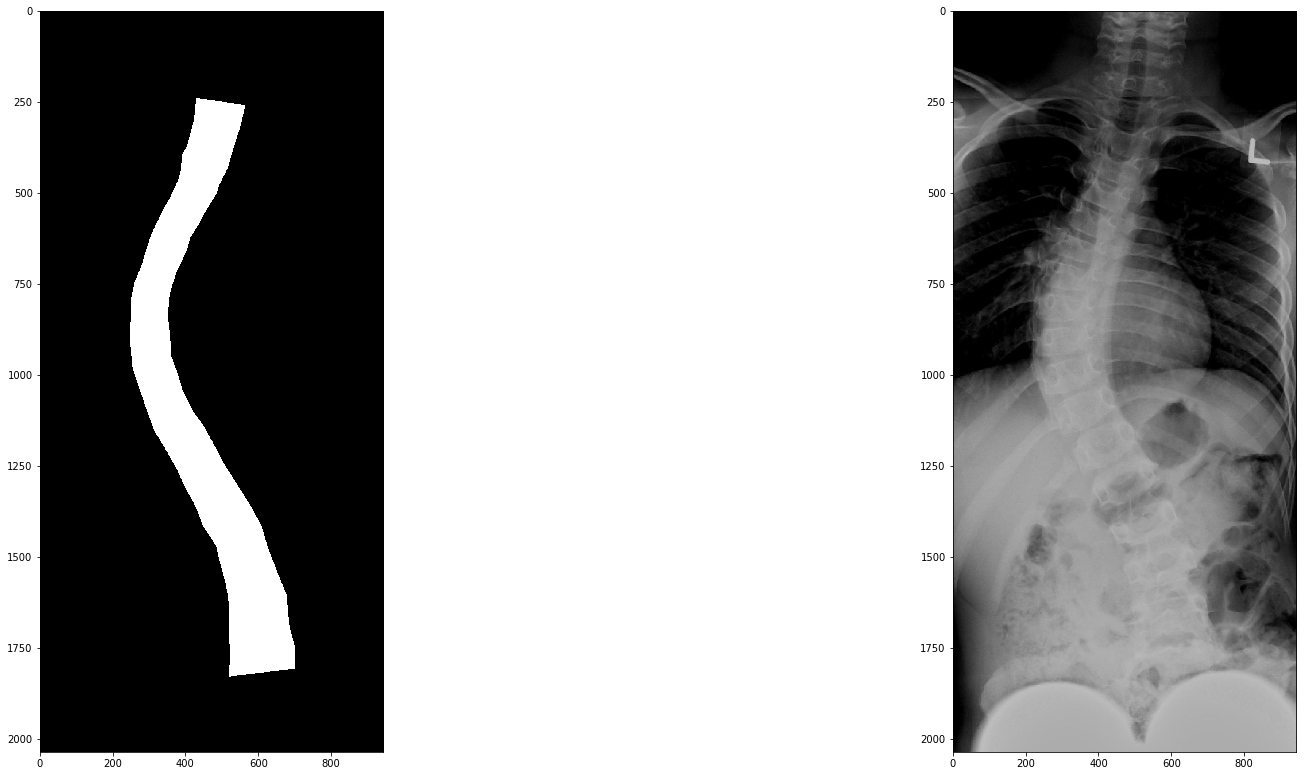

In [5]:
filename = "sunhl-1th-01-Mar-2017-311 E AP.jpg"
image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/test/"
label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/test/"
image = image_directory+filename


img = cv2.imread(image)
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)
print (img.shape)

# extract landmarks
indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmark= data.iloc[indx[0]].values
print (landmark)
cnt=[]

# take second element for sort
def takeSecond(elem):
    return elem[1]

# convert landmarks to image coordinates
left_side_coordinates=[[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (0,68,2)]
right_side_coordinates= [[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (67,0,-2)]

#sort the elements for continuous boundary
left_side_coordinates.sort(key=takeSecond)
right_side_coordinates.sort(key=takeSecond,reverse=True)
cnt=left_side_coordinates+right_side_coordinates

    

empty_image = np.zeros(img.shape,np.uint8)
cnt= np.array(cnt)
#print (cnt)

cv2.drawContours(empty_image,[cnt],-1,(255,255,255),-1)
plt.figure(1, figsize=(30,30))

plt.subplot(221)
plt.imshow(empty_image,cmap=cm.gray)

plt.subplot(222)
plt.imshow(img[:,:,::-1])

## Generate Ground Truth for Combined Landmarks detection ##

(2531, 729, 3)
144.17272313223836


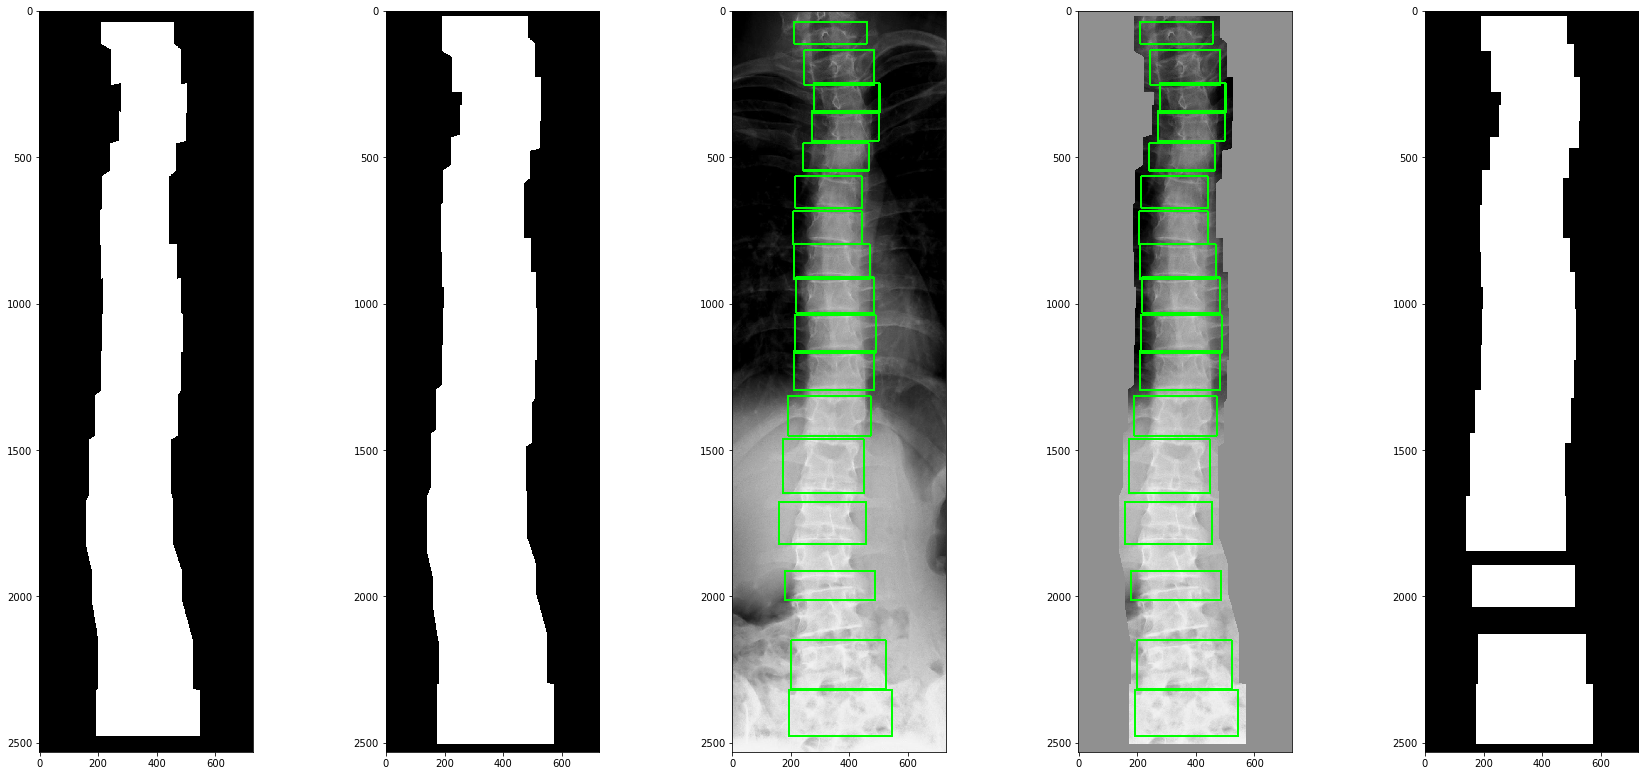

In [8]:
filename = "sunhl-1th-06-Jan-2017-182 A AP.jpg"
image_directory= "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/data/train/"
label_directory= "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/data/labels/train/"
image = image_directory+filename


img = cv2.imread(image)
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)
print (img.shape)



# extract landmarks
indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmarks= data.iloc[indx[0]].values



landmark = [[int(round(img.shape[1]*landmarks[m])),int(round(img.shape[0]*landmarks[m+68]))] for m in range (0,68)]

# group 4 corner landmarks to form box
N=4    
landmark_corners = [landmark[n:n+N] for n in range(0, len(landmark), N)]
landmark_corners= np.array(landmark_corners)
boxes= []

###### first method to segment spine 
blank_image= np.zeros(img.shape,np.uint8)
for box in landmark_corners:
    x,y,w,h = cv2.boundingRect(box)
    boxes.append([x-50,y-10,x+w+50,y+h+10])
    cv2.rectangle(img,(x-50,y-10),(x+w+50,y+h+10),(0,255,0),5)
    cv2.rectangle(blank_image,(x-50,y-10),(x+w+50,y+h+10),(255,255,255),-1)
    
kernel = np.ones((10,10),np.uint8)
blank_image = cv2.dilate(blank_image,kernel,iterations = 5)




##### second method to segment spine

boxes.sort(key=lambda x: x[1])
box_corners= []
box_corners_right_side=[]
box_corners_left_side=[]
for bb in boxes:
    top_left= bb[0:2]
    top_right= [bb[2],bb[1]]
    bottom_left=[bb[0],bb[3]]
    bottom_right=bb[2:4]
    box_corners.append([top_left,top_right,bottom_left,bottom_right])
    box_corners_left_side.append([top_left,bottom_left])
    box_corners_right_side.append([top_right,bottom_right])

box_corners_left_side=np.array( box_corners_left_side).reshape((17*2,2)).tolist()
box_corners_right_side= np.array(box_corners_right_side).reshape((17*2,2)).tolist()


# take second element for sort
def takeSecond(elem):
    return elem[1]



cnt= box_corners_left_side + box_corners_right_side[::-1]
cnt=np.array(cnt)

# create black image of img size
empty_image = np.zeros(img.shape,np.uint8)
binary_image= np.copy(empty_image)


cv2.drawContours(binary_image,[cnt],-1,(255,255,255),-1)
kernel = np.ones((10,10),np.uint8)

masked_img=np.copy(img)
dilated = cv2.dilate(binary_image,kernel,iterations = 5)
#masked_image = cv2.bitwise_and(img,blank_image) 

#makk= np.array([255,0,0])
#boll_mak= ~makk.astype(bool)
#print (boll_mak)
masked = np.ma.array(data= img, mask= ~dilated.astype(bool))
mean= np.mean(masked)
print (mean)
masked_img[dilated==0] = mean
#pixelpoints = masked_image[~np.all(masked_image == 0, axis=2)]


plt.figure(1, figsize=(30,30))

plt.subplot(251)
plt.imshow(binary_image,cmap=cm.gray)

plt.subplot(252)
plt.imshow(dilated,cmap=cm.gray)


plt.subplot(253)
plt.imshow(img[:,:,::-1])

plt.subplot(254)
plt.imshow(masked_img[:,:,::-1])

plt.subplot(255)
plt.imshow(blank_image, cmap=cm.gray)

## Generate segmentation ground for all images and save ##

Connects all the landmark points to generate a snake-like curve. This segmented curve is used as groundtruth to train image segmentation models like U-net.

In [ ]:

# take second element for sort
def takeSecond(elem):
        return elem[1]

image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/test/"
label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/test/"
ground_truth= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/test groundtruth/"
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)

i=0
for names in filename_labels.iloc[:,0]:

    img = cv2.imread(image_directory+names)
    #print (img.shape)
    landmark = data.loc[i].values
    #print (landmark)
    cnt=[]

    # convert landmarks to image coordinates
    left_side_coordinates=[[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (0,68,2)]
    right_side_coordinates= [[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (67,0,-2)]

    #sort the elements for continuous boundary
    left_side_coordinates.sort(key=takeSecond)
    right_side_coordinates.sort(key=takeSecond,reverse=True)
    cnt=left_side_coordinates+right_side_coordinates


    gnd_image = np.zeros(img.shape,np.uint8)
    cnt= np.array(cnt)

    cv2.drawContours(gnd_image,[cnt],-1,(255,255,255),-1)
    i+=1
    cv2.imwrite(ground_truth+names,gnd_image)

### Find the Z-score of boudning boxes' width and height separately

[176.47058824 114.        ]
[36.01816151 27.48903525]


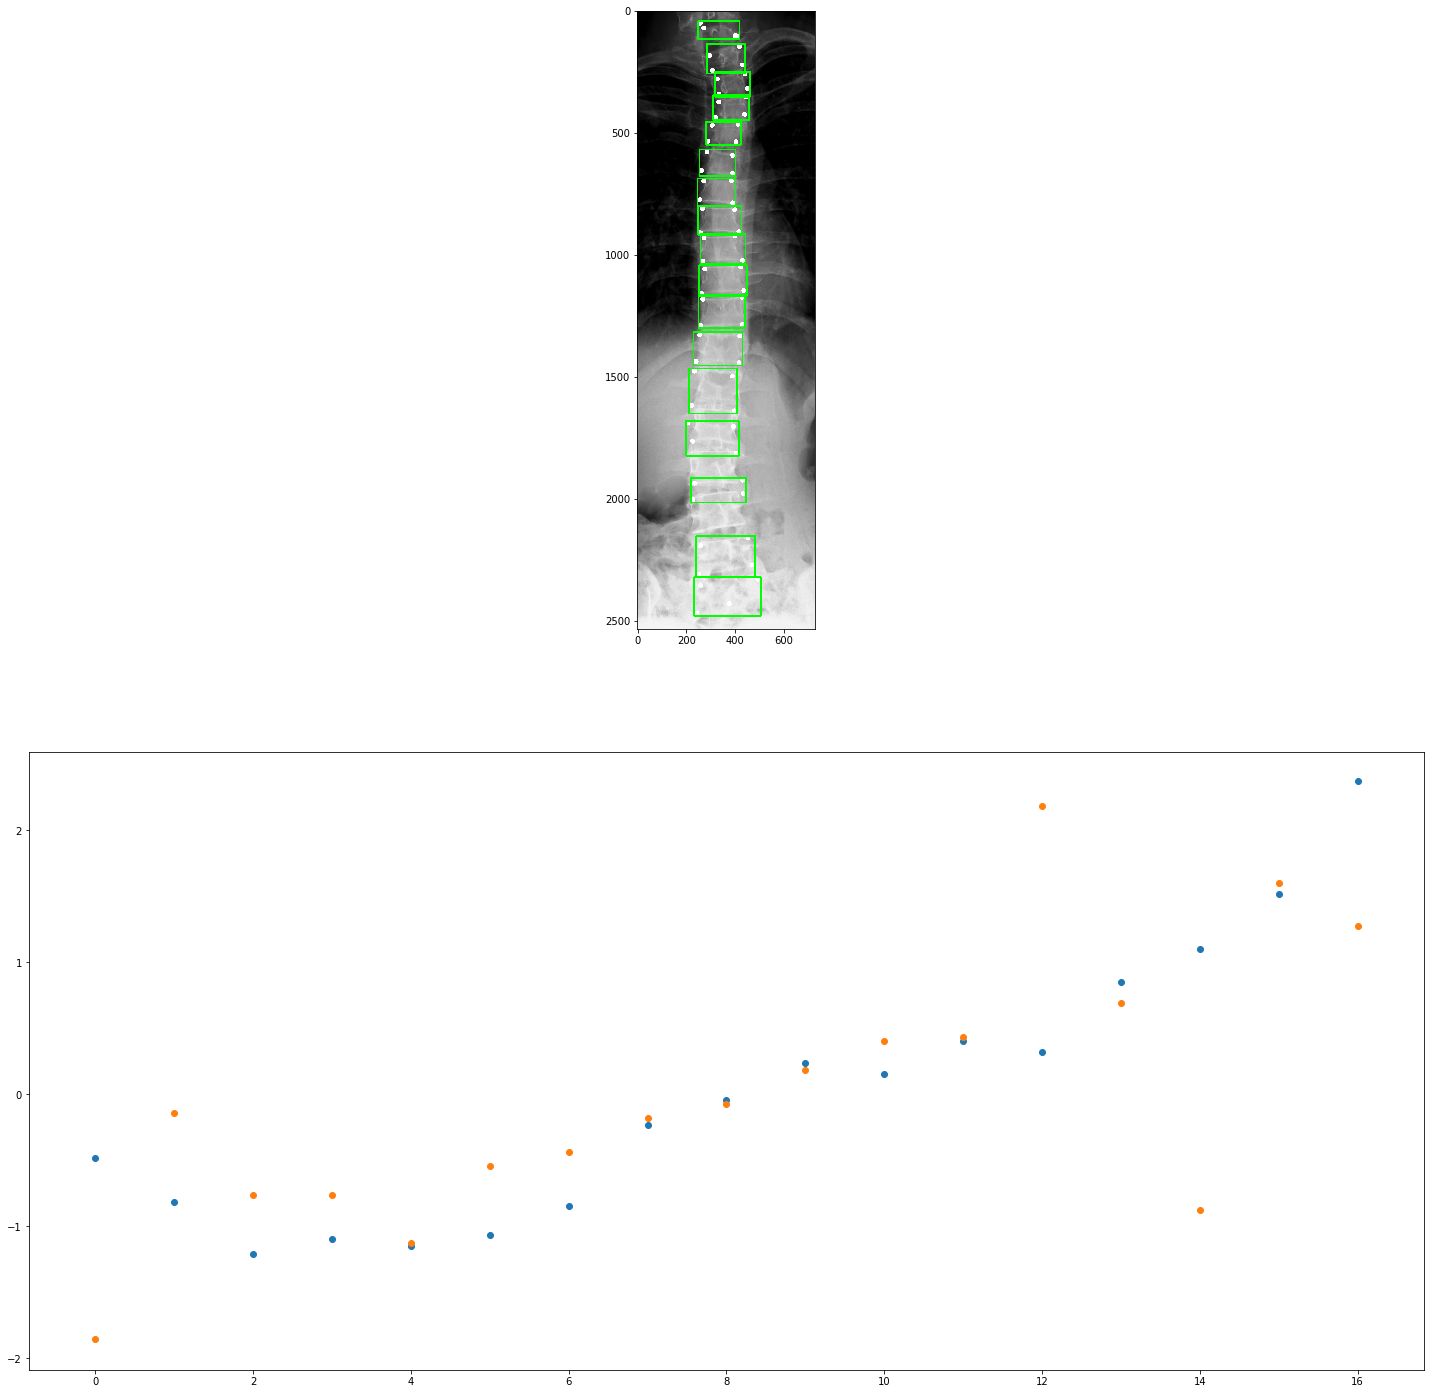

In [10]:

def zscore(bboxes):
    mean= np.mean(bboxes,axis= 0)
    std =np. std(bboxes,axis=0)
    z_score= (bboxes-mean)/std
    return z_score

filename = "sunhl-1th-06-Jan-2017-182 A AP.jpg"
#image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/training/"
#label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/training/"
image_directory= "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/data/train/"
label_directory= "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/data/labels/train/"
image = image_directory+filename


img = cv2.imread(image)

data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)


indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmark= data.iloc[indx[0]].values
for m in range(0,68):
    cv2.circle(img,(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])), 10, (255,255,255), -1)

landmark = [[int(round(img.shape[1]*landmark[m])),int(round(img.shape[0]*landmark[m+68]))] for m in range (0,68)]
#print (landmark)


N=4    
corners = [landmark[n:n+N] for n in range(0, len(landmark), N)]
corners= np.array(corners)

bboxes=[]
for box in corners:
    x,y,w,h = cv2.boundingRect(box)    
    cv2.rectangle(img,(x-10,y-10),(x+w+10,y+h+10),(0,255,0),5)
    bboxes.append((w+10,h+10))
    

    
print (np.mean(bboxes,axis=0))
print (np.std(bboxes,axis=0))
Z_score = zscore(bboxes)
#print (Z_score)


plt.figure(1, figsize=(25,25))




#print (Z_score.shape[0],Z_score[1])
#print (Z_score[:,0])

plt.subplot(211)
plt.imshow(img[:,:,::-1])

plt.subplot (212)
plt.scatter( x=np.arange(Z_score.shape[0]), y= Z_score[:,0], alpha=1)
plt.scatter( x=np.arange (Z_score.shape[0]),y= Z_score[:,1], alpha=1)
plt.show()


In [12]:
def zscore(bboxes):
    mean= np.mean(bboxes,axis= 0)
    std =np. std(bboxes,axis=0)
    z_score= (bboxes-mean)/std
    return z_score

In [13]:
def bbox_zscore(image_directory, filenames_csv, landmarks_csv, split_type= 'train'):
    
    landmarks_data= pd.read_csv(landmarks_csv,header= None)
    filename_labels= pd.read_csv(filenames_csv,header= None)
    All_bboxes=[]
    
    for i, names in enumerate(filename_labels.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        #print (names)
        #print ("image shape",img.shape)
        landmarks = landmarks_data.loc[i].values
        landmarks = [[int(round(img.shape[1]*landmarks[m])),int(round(img.shape[0]*landmarks[m+68]))] for m in range (0,68)]
        
        # group landmark coordinates, each group has 4 points that represents a vertebra
        N=4     
        box = [landmarks[n:n+N] for n in range(0, len(landmarks), N)]
        #print (box)
        box= np.array(box)
        
        for c, box_coordinates in enumerate(box):
            x,y,w,h = cv2.boundingRect(box_coordinates) 
            All_bboxes.append((w+10,h+10))
    All_bboxes=np.array(All_bboxes)
    print (np.mean(All_bboxes,axis=0))
    print (np.std(All_bboxes,axis=0))
    Z_score = zscore(All_bboxes)
    print (np.argmax(Z_score[:,1]))
    plot_zscore(Z_score)
    
            

In [14]:
def plot_zscore(Z_score):
    
    plt.figure(1, figsize=(25,25))
    
    plt.subplot(221)
    plt.scatter( x=np.arange(Z_score.shape[0]), y= Z_score[:,0], c= 'red', alpha=1)
    plt.xlabel('vertebra')
    plt.ylabel('width')
    
    plt.subplot(223)
    plt.scatter( x=np.arange (Z_score.shape[0]),y= Z_score[:,1], c= 'blue', alpha=1)
    plt.xlabel('vertebra')
    plt.ylabel('height')
    
    
    plt.subplot(222)
    ax=sns.boxplot( y= Z_score[:,0],palette="Set1", whis= 2)
    ax.set(title= 'Boxplot' ,ylabel='Width')
    
    plt.subplot(224)
    ax=sns.boxplot( y= Z_score[:,1],palette="Set1", whis= 2)
    ax.set(title= 'Boxplot' ,ylabel='height') 
    
    plt.show()


[188.72116913 127.47022135]
[46.36922692 40.09567407]
4623


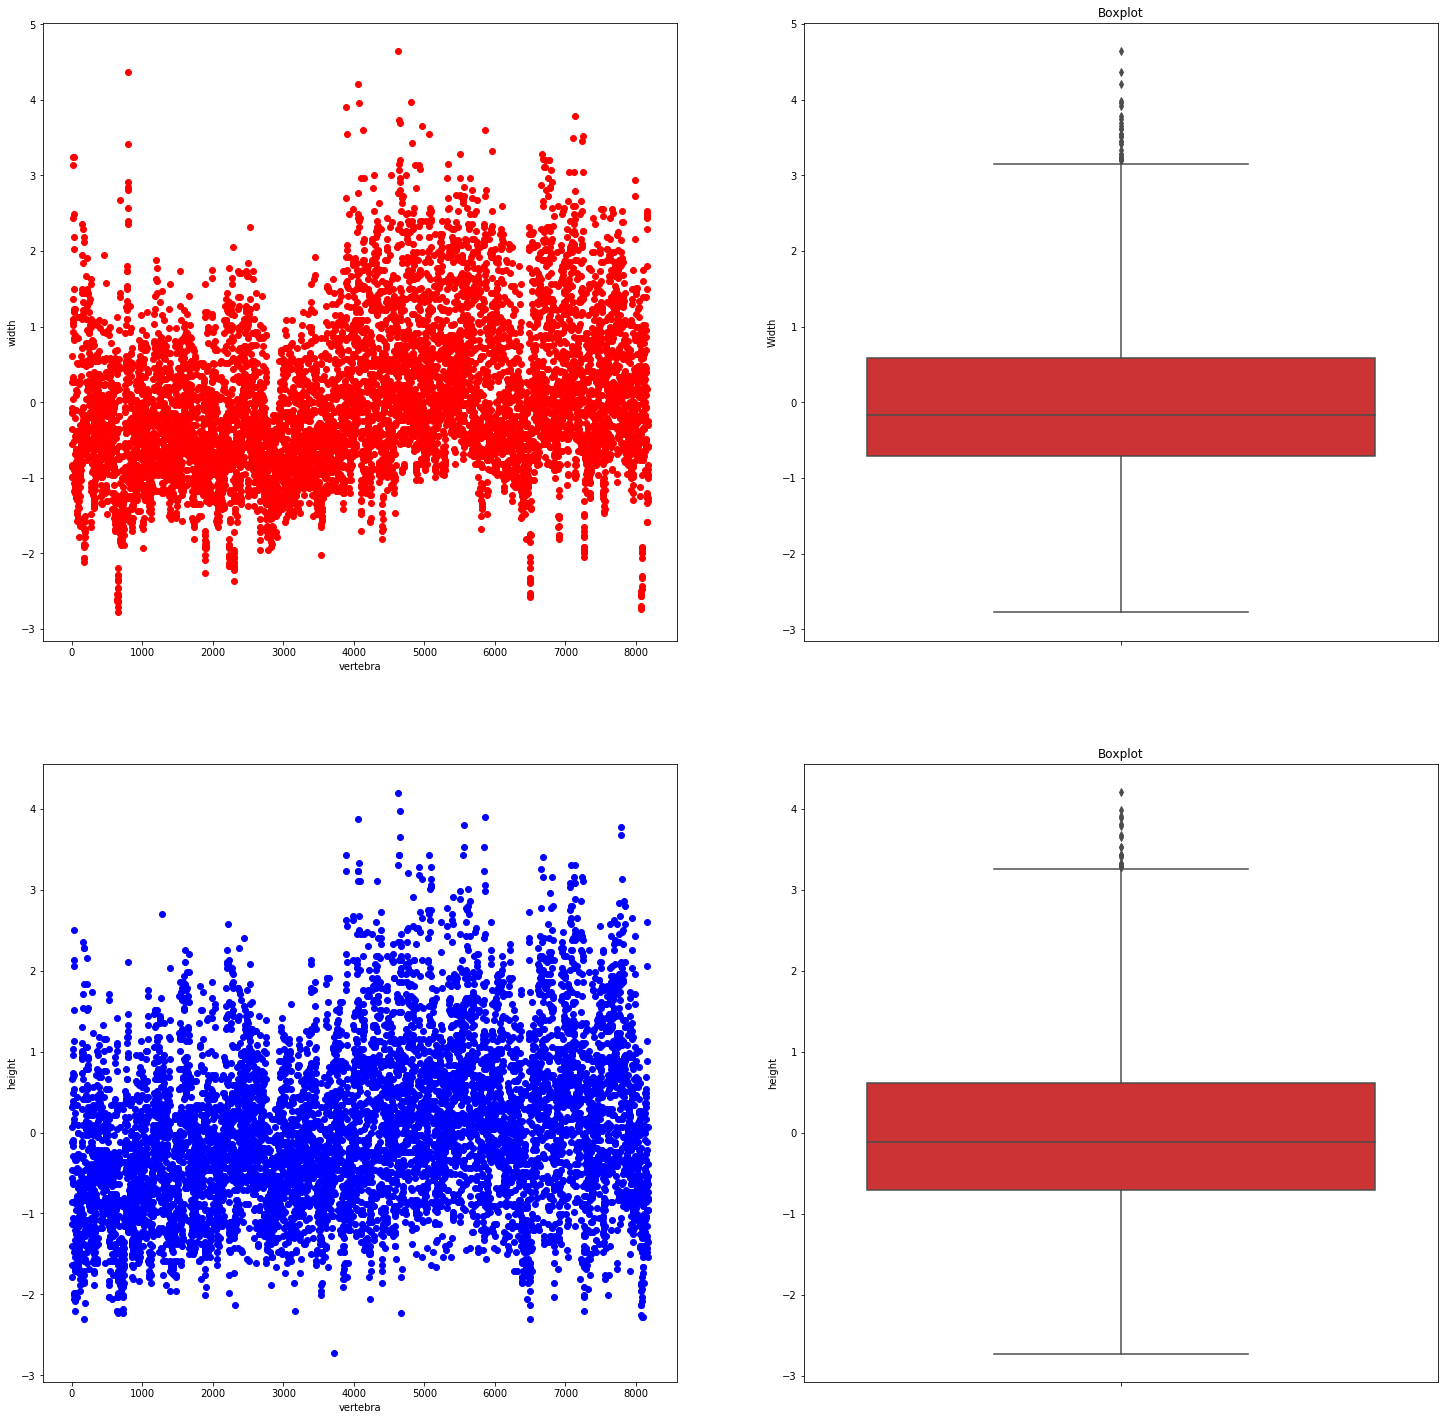

In [15]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/"
train_data_directory = os.path.join(ROOT_PATH, "data/train/")
val_data_directory = os.path.join(ROOT_PATH, "data/val/")
train_label_directory=os.path.join(ROOT_PATH, "data/labels/train/")
val_label_directory =os.path.join(ROOT_PATH, "data/labels/val/")



bbox_zscore(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),
         os.path.join(train_label_directory,'landmarks.csv'), 'train')

#bbox_zscore(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),
#        os.path.join(val_label_directory,'landmarks.csv'), 'val')

## Image pre-processing portion

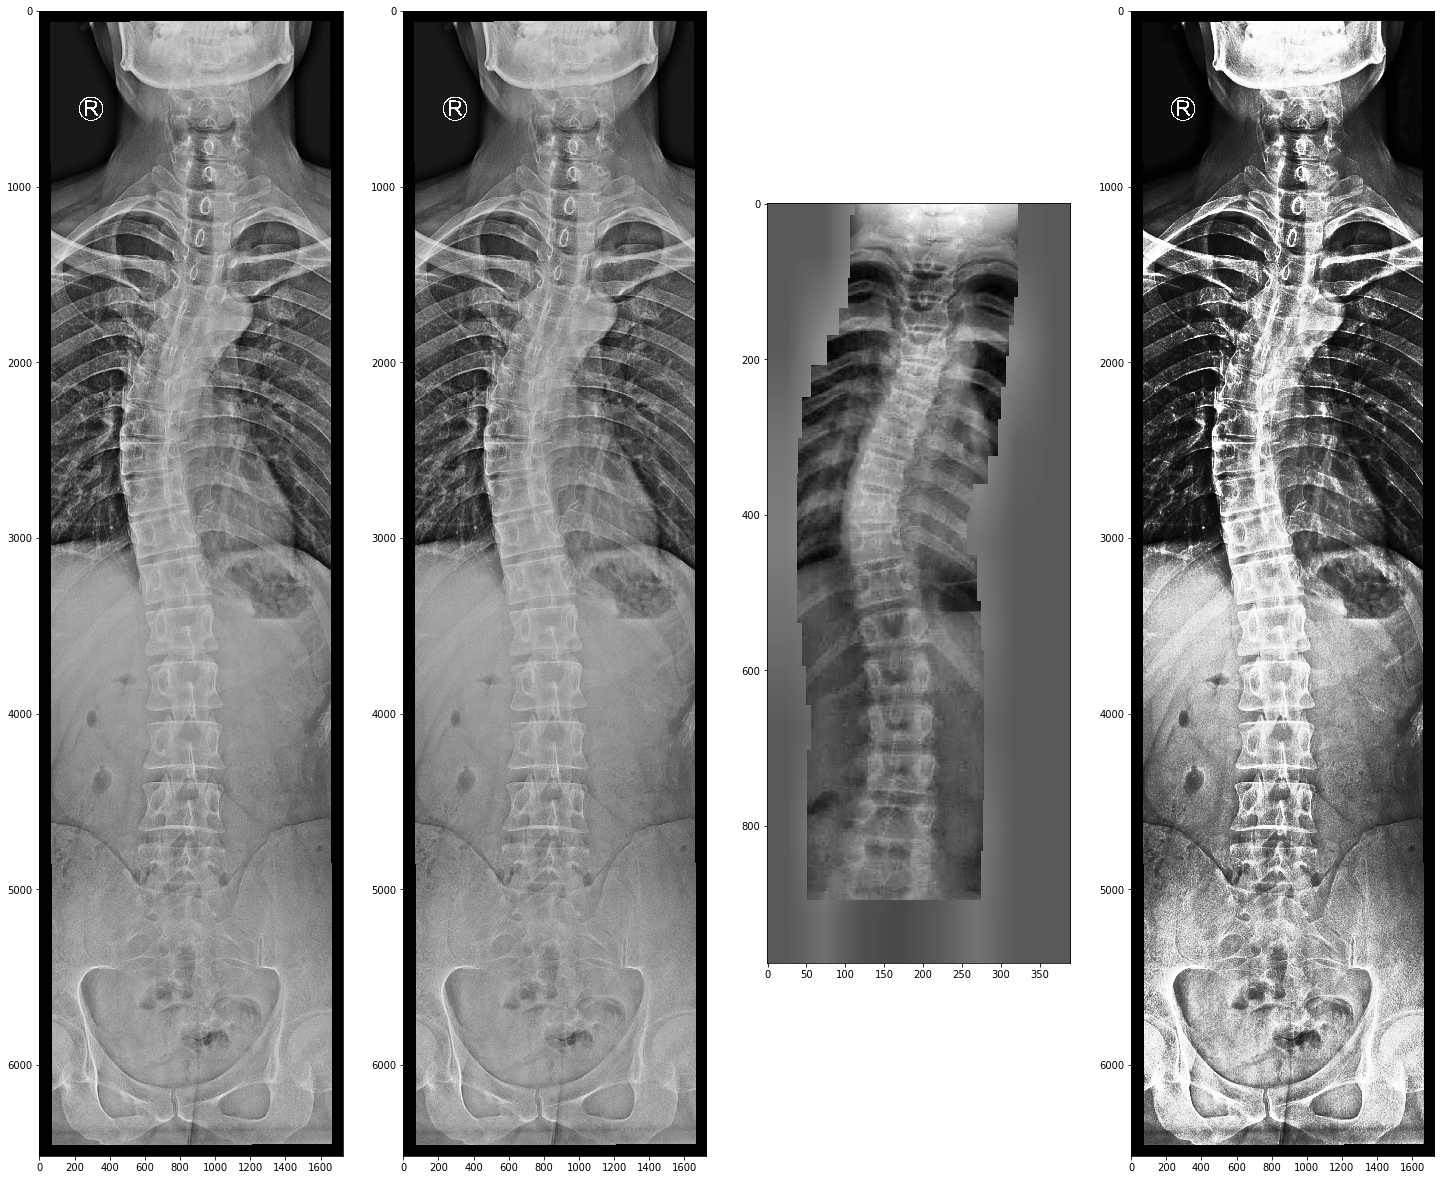

In [17]:
filename = "01-July-2019-8.jpg"
image_directory= "C:/Users/Brinda Khanal/Downloads/Archive/"

image = image_directory+filename


img = cv2.imread(image,0)



equ = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

#blur = cv2.bilateralFilter(img,10,75,75)
#blur= cv2.GaussianBlur(img,(7,7),2)
normalized= img/255.
normalized = (normalized-0.4847341)/0.216084388
normalized=normalized*255
    

plt.figure(1, figsize=(25,25))


plt.subplot(141)
plt.imshow(img, cmap= cm.gray)

plt.subplot (142)
plt.imshow(normalized, cmap= cm.gray)

plt.subplot (143)
plt.imshow(cl1, cmap= cm.gray)

plt.subplot (144)
plt.imshow(equ, cmap= cm.gray)


# Smoothen All Test Images

In [4]:
def smoothen(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        blur = cv2.bilateralFilter(img,15,75,75)
        #im=cv2.resize(blur,(600,1024),interpolation=cv2.INTER_AREA)
        print (blur.shape)
        cv2.imwrite (save_path+names,im)
        
    

In [ ]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/"
test_data_directory = os.path.join(ROOT_PATH, "data/test/")
test_label_directory=os.path.join(ROOT_PATH, "data/labels/")
save_path = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/resized test image/"
smoothen(test_data_directory,os.path.join(test_label_directory,'test_filenames.csv'),save_path)


# Intelligent Crop #

In [2]:
def intelligent_crop(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        height=img.shape[0]
        width= img.shape[1]
        ratio = height/width
        upper_crop=0.15
        lower_crop=0.25
        print (height*0.2*(ratio/3.75),height*(1-0.21*(ratio/3.75)))
        cropped_image=img[int(height*0.2*(ratio/3.75)):int(height*(1-0.21*(ratio/3.75))),0:width]
        cv2.imwrite (save_path+names,cropped_image)

In [ ]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/"
test_data_directory = os.path.join(ROOT_PATH, "test cropped/org/")
test_label_directory=os.path.join(ROOT_PATH, "Object detection/data/labels/")
save_path = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/test cropped/crop/"
intelligent_crop(test_data_directory,os.path.join(test_label_directory,'test_filenames.csv'),save_path)


# Normalize the images

In [22]:
def z_normalize(image):
    print (image.shape)
    mean = image.mean(axis=(0,2),dtype='float64')
    std =  image.std(axis=(0,2), dtype='float64')
    print (mean,std)
    return ((image-mean)/std,mean)

In [23]:
def find_normalized_max_min(image_directory, filenames_csv, save_path, split_type= 'train'):
    
    
    image_filenames= pd.read_csv(filenames_csv,header= None)
    image_min=[]
    image_max=[]
    image_mean=[]
    
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        print (names)
        z_norm_img,mean=z_normalize(img) 
        # convert pixel values in range[0,255]
        #norm_image = cv2.normalize(z_norm_img, None, alpha = np.min(z_norm_img), beta = np.max(z_norm_img),
        #                           norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        if split_type not in os.listdir(save_path):
            os.mkdir(save_path+split_type)
        image_min.append(np.min(z_norm_img))
        image_max.append(np.max(z_norm_img))
        print(mean)
        image_mean.append(mean)
        
        #cv2.imwrite(save_path+split_type+'/'+names,z_norm_img)
    print(np.mean(np.array(image_mean),axis=0))
    image_min=np.array(image_min)
    image_max=np.array(image_max)
    return (np.max(image_max),np.min(image_min))
        
        
    
    
    
    
    

In [18]:
def save_normalize_image(image_directory, filenames_csv, save_path,maximum,minimum, split_type= 'train'):
    
    
    image_filenames= pd.read_csv(filenames_csv,header= None)
    image_min=[]
    image_max=[]
    
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        print (names)
        z_norm_img=z_normalize(img) 
        img_viz = ((z_norm_img-(minimum))/(maximum-minimum))*255
        img_viz= img_viz.astype(int)
        # convert pixel values in range[0,255]
        #norm_image = cv2.normalize(z_norm_img, None, alpha = np.min(z_norm_img), beta = np.max(z_norm_img),
        #                           norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        if split_type not in os.listdir(save_path):
            os.mkdir(save_path+split_type)
        
        
        
        cv2.imwrite(save_path+split_type+'/'+names,img_viz)
    

In [28]:
def combine_all_images(image_directory,filenames_csv):
    image_filenames= pd.read_csv(filenames_csv)
    #print (image_filenames)
    images=[]
    for i, names in enumerate(image_filenames['image_id'] ):

        img = cv2.imread(image_directory+names,0)
        img=img/255.
        images.append(img)
        print (names)
    images= np.array(images)
    normalized= z_normalize(images)
        
    
    

In [ ]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Landmark estimation/"
train_data_directory = os.path.join(ROOT_PATH, "train_patch_images/")
val_data_directory = os.path.join(ROOT_PATH, "val_patch_images/")

combine_all_images(train_data_directory,os.path.join(ROOT_PATH,'train_patches_gnd.csv'))
#combine_all_images(val_data_directory,os.path.join(ROOT_PATH,'val_patches_gnd.csv'))

In [ ]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/"
train_data_directory = os.path.join(ROOT_PATH, "data/train/")
val_data_directory = os.path.join(ROOT_PATH, "data/val/")
train_label_directory=os.path.join(ROOT_PATH, "data/labels/train/")
val_label_directory =os.path.join(ROOT_PATH, "data/labels/val/")
save_path = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/normalized images/"


(maximum,minimum)= find_normalized_max_min(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),save_path, 'train')
#save_normalize_image(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),save_path,maximum, minimum, 'train')


#(x,y)= normalize_image(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),save_path, 'val')
print (maximum,minimum)

## Add Gaussian Noise

In [24]:
'''parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.'''


import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 255
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        cv2.normalize(noisy, noisy, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        noisy = noisy.astype(np.uint8)
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy

    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

(2125, 755, 3)


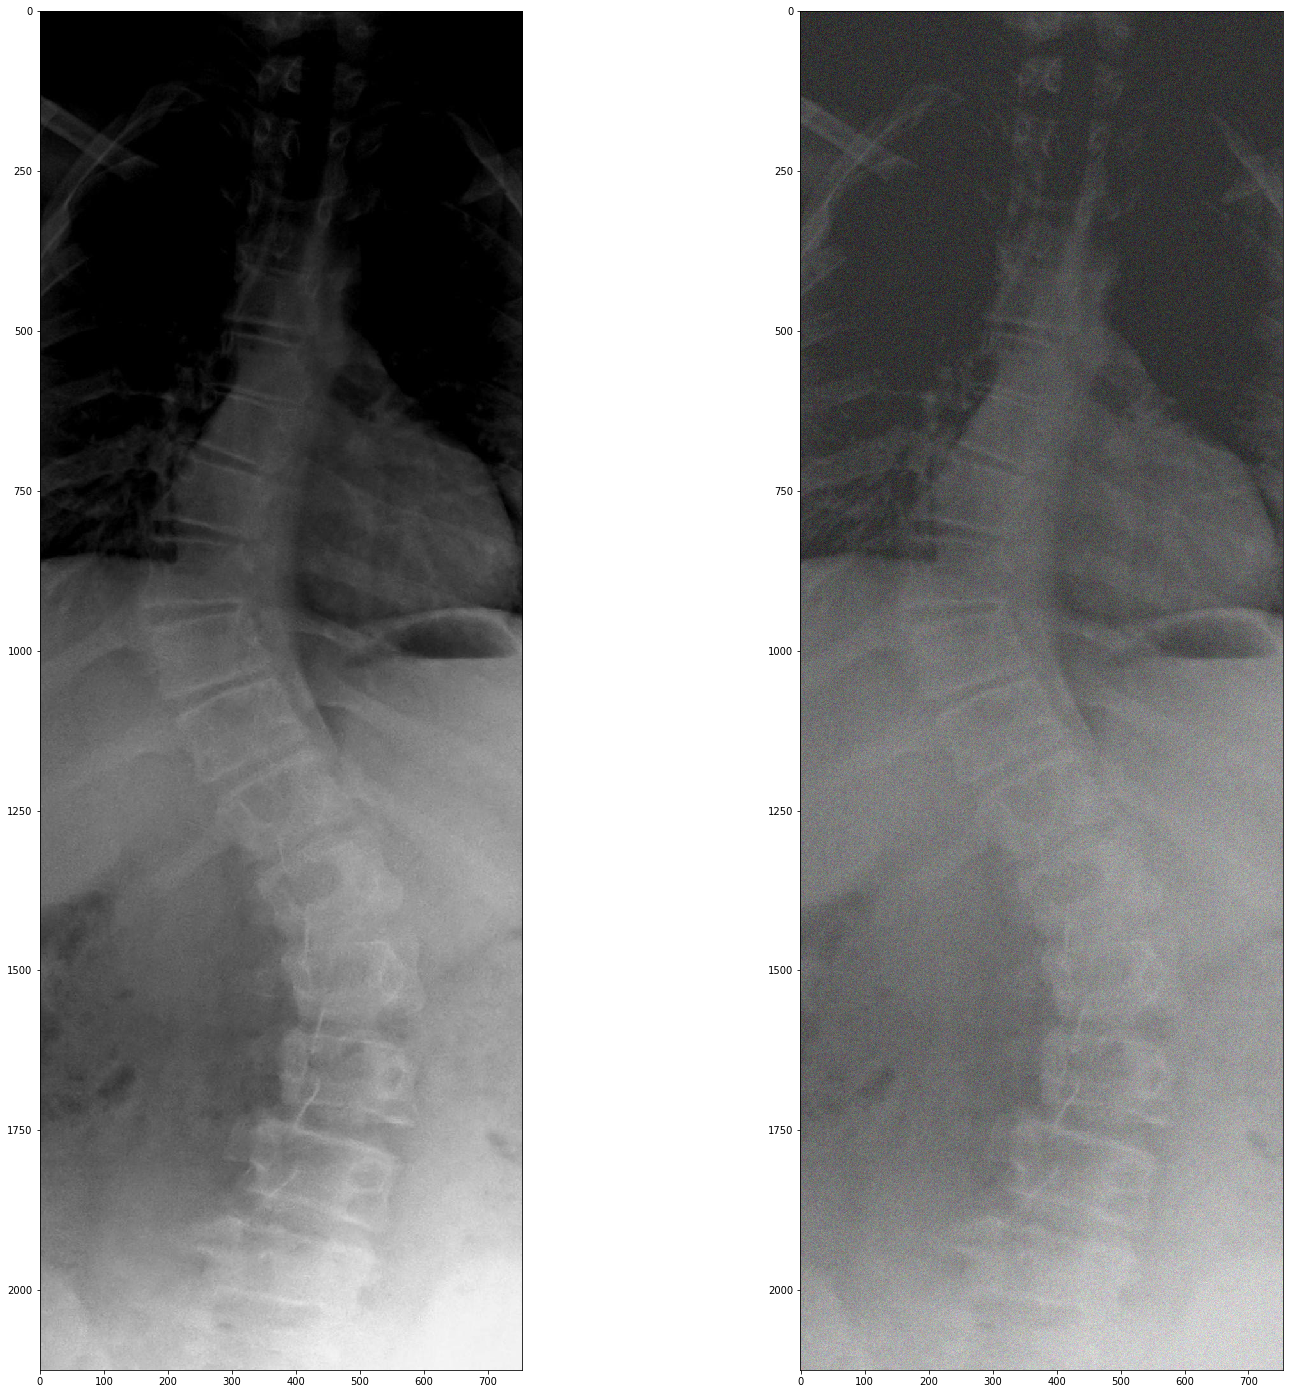

In [25]:
filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
image_directory= "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/data/train/"


image = image_directory+filename


img = cv2.imread(image)
print (img.shape)

gau_img= noisy('gauss',img)
plt.figure(1, figsize=(25,25))


plt.subplot(121)

plt.imshow(img[:,:,::-1])

plt.subplot(122)

plt.imshow(gau_img[:,:,::-1])



In [26]:
def gauss_all_img(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        gau_img= noisy('gauss',img)
        cv2.imwrite (save_path+'gauss_'+names,gau_img)

In [27]:
ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/"
train_data_directory = os.path.join(ROOT_PATH, "data/train/")
val_data_directory = os.path.join(ROOT_PATH, "data/val/")
train_label_directory=os.path.join(ROOT_PATH, "data/labels/train/")
val_label_directory =os.path.join(ROOT_PATH, "data/labels/val/")
save_path_train = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/gaussian_noise/train/"
save_path_val = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/gaussian_noise/val/"

gauss_all_img(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),save_path_train)
gauss_all_img(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),save_path_val)









In [ ]:
import tensorflow as tf
# Build a dataflow graph.
v = tf.placeholder(tf.float32, [1, None, None, 3], name='x-input')
mean,var=tf.nn.moments(v,(1,2))
print (mean.dtype)
inputs= (v-mean)/tf.sqrt(var)
with tf.Session() as sess:
    print(sess.run(inputs, feed_dict={v:[[[[1, 4, 3],[1, 2, 3]],[[7,2,3],[1,2,2]]]]}))
    

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, layers, models

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

def customLossThatWorks():
    return tf.keras.losses.sparse_categorical_crossentropy

# def customLoss(y_true, y_pred):
#     return K.sparse_categorical_crossentropy(y_true, y_pred)

# def customLoss():
#     def loss(y_true,y_pred):
#         return K.sparse_categorical_crossentropy(y_true, y_pred)
#     return loss
    
# def customLoss():
#     def loss(y_true,y_pred):
#         return tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
#     return loss

# copied from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/losses.py#L867
def customLoss(y_true, y_pred):
    y_true= tf.Print(y_true,[y_true],"y_true=")
    y_pred= tf.Print(y_pred,[y_pred],"y_pred=")
    return K.sparse_categorical_crossentropy(
      y_true, y_pred)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss=customLoss, optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
model.fit(train_images, train_labels, epochs=1)